# Exercise 2: Netflix Recommendation Algorithm

<img src="https://i.pcmag.com/imagery/reviews/05cItXL96l4LE9n02WfDR0h-5.fit_lim.size_1200x630.v1582751026.png" width="40%">

Do not start the exercise until you fully understand the submission guidelines, which can be found here.

For any material-related-questions, ask Ami. For any organization-related-questions, ask Lior.


#### **Read the following instructions carefully:**
1. Write your functions in this notebook only. Do not create Python modules and import them.
Feel free to add code blocks if you need.
2. Answers to qualitative questions should be written in markdown cells (with  LATEX  support). Answers that will be written in commented code blocks will not be checked.
3. Kind reminder: the total of all exercises weight is 50% of the course's grade!

#### **This exercise summarizes the following subjects:**
1. **Netflix's recommendation algorithm:**

  1.1. Content Filtering

  1.2. Collaborative Filtering

  1.3. Filling missing values in the Rating Matrix

  1.4. Matrix Factorization

  1.5. Data correlation finding approaches: SVD, PCA


2. **Applications of SVD and PCA:**

  2.1. Face images compression and recognition using PCA

  2.2. Hand written digits recognition using SVD/PCA

  2.3. Correlations detection of mutations in the genom and different populations using SVD/PCA


# Part 1: Netflix's Recommendation Algorithm

We demonstrated in class how to find similar movies (and recommend movies to a user, similar to a movie he likes), using **Ratings Matrix** where a list of users partially rated a list of movies. In class, we demonstarted 2 ways to handle the Rating Matrix using Excel sheets:

1. Calculate similarities (distances) between movies using the 1 to 5 rating values.
2. Turn the Rating Matrix into a **boolean** matrix where R(i,j)=TRUE if User i rated movie j above some threshold TH (1<=TH<=5).
Note that if TH=1 we get a rating matrix where **any** rating of a movie become TRUE in the boolean rating matrix. As mentioned in class, even such elementary representation is, supresingly, good data to work with.

In [ ]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.metrics import mean_squared_error

import zipfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Add more imports if necessary:

## Question 1 (20 points)

In this question you will write a code that, based on the students' rating matrix (attached to the homework assignment file: our_course_ratings.csv), generates recommendations Ratings Matrix as demonstrated in class.

1.1 Write a function `read_matrix()` that reads `our_course_ratings.csv` file into memory. Do not forget to ignore null values.
  * `our_course_ratings.csv` file is a matrix where each cell contains the rating that student `j` rated movie `i`.

1.2 Write a function `create_boolean_matrix()` that converts our rating matrix into a 1/0 matrix.

1.3 Write a function `recommendation_alg()`:
* The function should prompt the user to enter the first letter of a movie they like.
* Validate the user input to ensure it is a single letter.
* Display a list of movies whose names start with the entered letter.
* Ask the user to choose a movie from the list.
* Calculate movie recommendations based on the chosen movie.
* Print and return a list of k recommended movie names.

1.4 Test your results and run `recommendation_alg()` 3 times:
* Choose the movie **Harry Potter and the Deathly Hallows, Part 2 (2011)**.
* Choose the movie **Star Wars: Episode IV - A New Hope (1977)**.
* Choose your **favorite movies** (one for each student).

In [ ]:
def read_matrix(matrix):
  """
  Reads a rating matrix from a CSV file, performs preprocessing, and returns the matrix along with movie names and student names.

  Params:
  - matrix: The CSV file containing the rating matrix.

  Return:
  - A tuple (M, moviesNames, studentsNames) where M is the rating matrix, moviesNames is a series of movie names, and studentsNames is a list of student names.
  """
  lines = []
  with open(matrix, newline='') as f:
    spamreader = csv.reader(f)
    for row in spamreader:
        lines.append(row)

  students = lines[0][2:]
  movies = []
  rating_matrix = []

  for ratings in lines[3:]:
    movies.append(ratings[1])
    rating_matrix.append([int(rating) if rating.isnumeric() else None for rating in ratings[2:]])

  return rating_matrix, movies, students

M, moviesNames, studentsNames = read_matrix('our_course_ratings.csv')

In [ ]:
def create_boolean_matrix(matrix, TH = 3):
  """
  Creates a boolean matrix from the given input matrix by setting values below the threshold (TH) to 0 and others to 1.

  Params:
  - matrix: The input matrix to be converted into a boolean matrix.
  - TH: The threshold value; values less than TH are set to 0, and others to 1.

  Returns:
  - The boolean matrix with the same shape as the input matrix.
  """
  return [[
      0 if rating is None or rating < TH else 1
      for rating in movie_ratings
  ] for movie_ratings in matrix]

bool_M = create_boolean_matrix(M)

In [ ]:
def recommendation_alg(M, moviesNames, TH=3, k: int = 3):
    """
    Receives a movie the user likes and returns k other movies he might like.

    Params:
    - M: a ratings matrix
    - moviesNames: a movie names matrix
    - TH: the threshold value
    - k: number of best results to return

    Returns:
    - k other movies he might like, by names, not ids
    """
    selected_movie = get_movie_name(moviesNames)
    selected_movie_index = next(index for index, movie in enumerate(moviesNames) if movie == selected_movie)

    binary_rating_matrix = create_boolean_matrix(M, TH)
    selected_movie_ratings = binary_rating_matrix[selected_movie_index]

    movies_by_similarity = sorted(
        (mean_square_error(selected_movie_ratings, other_movie_ratings), movie_index)
        for movie_index, other_movie_ratings in enumerate(binary_rating_matrix)
        if not movie_index == selected_movie_index
    )

    return [
        moviesNames[index] for (_d, index) in movies_by_similarity[:k]
    ]


def get_movie_name(movieNames):
  first_letter_of_movie = None

  while not first_letter_of_movie:
    print("\n\nEnter the first letter of the movie:")
    user_input = input()

    if len(user_input) == 1:
      first_letter_of_movie = user_input

  options = [movie for movie in movieNames if movie.lower().startswith(first_letter_of_movie.lower())]
  options_string = '\n'.join(options)

  movie_selected = None

  while not movie_selected:
    print(f"\n\nPlease select one of:\n{options_string}")
    user_input = input()

    if user_input in options:
      movie_selected = user_input

  print(f"\n\nYou have selected: '{movie_selected}'")

  return movie_selected


def mean_square_error(movie1_ratings, movie2_ratings):
  return sum((rating1 - rating2) ** 2 for (rating1, rating2) in zip(movie1_ratings, movie2_ratings)) / len(movie1_ratings)

# Test the content filtering recommendation algorithm
suggestions = recommendation_alg(M, moviesNames, k=3)
print(f"Suggestions = {suggestions}")

suggestions = recommendation_alg(M, moviesNames, k=3)
print(f"Suggestions = {suggestions}")

suggestions = recommendation_alg(M, moviesNames, k=3)
print(f"Suggestions = {suggestions}")



Enter the first letter of the movie:
h


Please select one of:
Harry Potter and the Deathly Hallows, Part 2 (2011)
Harry Potter and the Sorcerer's Stone (2001)
Harry Potter and the Deathly Hallows, Part 1 (2010)
Harry Potter and the Order of the Phoenix (2007)
Harry Potter and the Half-Blood Prince (2009)
Harry Potter and the Goblet of Fire (2005)
Harry Potter and the Chamber of Secrets (2002)
Hi, Mom (2021)
Harry Potter and the Prisoner of Azkaban (2004)
Harakiri (1962)
High and Low (1963)
Hamilton (2020)
Heat (1995)
Howl's Moving Castle (2004)
Harry Potter and the Deathly Hallows: Part 2 (2011)
Hacksaw Ridge (2016)
How to Train Your Dragon (2010)
Hotel Rwanda (2004)
Hachi: A Dog's Tale (2009)
Harry Potter and the Deathly Hallows, Part 2 (2011)


You have selected: 'Harry Potter and the Deathly Hallows, Part 2 (2011)'
Suggestions = ['Harry Potter and the Deathly Hallows, Part 1 (2010)', 'Harry Potter and the Half-Blood Prince (2009)', "Harry Potter and the Sorcerer's Stone (2001)"]


## Question 2 (40 points)

In this question you will write some functions that, using SVD analysis of the rating matrix, does the following 3 tasks:
1. Show X=3 movies most similar to a certain movie.
1. Shows X=3 users most similar to a certain user.
1. Recommend X=3 movies to a user based on the vector representing the user preferences in martix $V^T$ and the movies data in matrix $U$.


You can look at the following implementations of SVD analysis to make sure your write the SVD analysis correct ([1](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/)) , ([2](https://www.section.io/engineering-education/singular-value-decomposition-in-python/)).

##### **2.1 Write a function `calculateSpecificRating()` that performs matrix factorization (SVD) to calculate the specific rating of a user for a movie (5 points).**

Follow the steps below:

   * Ensure correct usage of the original rating matrix, $M$.
   
   $M$ should have **users** as its **columns** and **movies** as its **rows**.

   * You are allowed to use built-in Python functions to perform SVD on the ratings matrix $M$.

   * Calculate column i=1 of $M$, using the obtained matrices $U, S, V$ and compare the results to the original $M$.

   * Calculate row j=15 of $M$ using the matrices $U, S, V$ and compare the results to the original $M$.

   Note: If the printed values are **not exactly** the same as the original rating matrix column and row, do **not** proceed. Check your code and fix any discrepancies.

In [ ]:
# print(type(M))
# print(type(M[0]))
# print(np.shape(M))
# print(np.ndim(M))

def convert_to_numpy_array(M):
    """
    Converts a matrix to a numpy array.

    Params:
    - M: The matrix to be converted.

    Returns:
    - The converted numpy array.
    """
    max_length = max(len(row) for row in M)
    nested_list = [row + [None] * (max_length - len(row)) for row in M]

    nested_array = np.array(nested_list, dtype=object)
    nested_array= nested_array.astype('float')
    nested_array=np.nan_to_num(nested_array, nan=0)
    nested_array= nested_array.astype('uint8')
    return nested_array

M_numpy=convert_to_numpy_array(M)

# print(type(M_numpy))
# print(M_numpy[41, 0])
# print(np.shape(M_numpy))
# print(np.ndim(M_numpy))


In [ ]:
U, S, V = np.linalg.svd(M_numpy, full_matrices=True)

def calculateSpecificRating(U, S, V, row, column):
    """
    Calculate the specific rating of a user for a movie using SVD.

    Params:
    - U: Left singular vector matrix
    - S: Singular values matrix
    - V: Right singular vector matrix
    - row: Index of the movie
    - column: Index of the user

    Returns:
    - The calculated rating for the user at the specified column to the movie at the specified row.
    """
    return calculateMatrix(U, S, V)[row][column]

def calculateSpecificRatingFromMatrix(M, row, column):
    """
    Calculate the specific rating of a user for a movie using SVD.

    Params:
    - U: Left singular vector matrix
    - S: Singular values matrix
    - V: Right singular vector matrix
    - row: Index of the movie
    - column: Index of the user

    Returns:
    - The calculated rating for the user at the specified column to the movie at the specified row.
    """
    return M[row][column]


def calculateMatrix(U, S, V):
    """
    Calculate the specific rating of a user for a movie using SVD.

    Params:
    - U: Left singular vector matrix
    - S: Singular values matrix
    - V: Right singular vector matrix
    - row: Index of the movie
    - column: Index of the user

    Returns:
    - The calculated rating for the user at the specified column to the movie at the specified row.
    """

    smat = np.zeros((U.shape[0], V.shape[0]))
    smat[:V.shape[0], :V.shape[0]] = np.diag(S)
    SV = np.dot(smat,V)
    return np.round(np.dot(U, SV)).astype('uint8')

calculateSpecificRating(U, S, V, 2, 3)
# calculateMatrix(U, S, V)


5

In [ ]:
def compareArr(arr1, arr2):
    return np.allclose(arr1, arr2)

In [ ]:
col1 = []
col1=calculateMatrix(U, S, V)[:,1]
print("comparison to col1: ", compareArr(col1, M_numpy[:,1]))

row15 = []
row15=calculateMatrix(U, S, V)[15,:]
print("comparison to row15: ", compareArr(row15, M_numpy[15,:]))

comparison to col1:  True
comparison to row15:  True


In [ ]:
# These should print the exact same values:
print(f'The value at M[0,1] is: {M_numpy[0,1]}, and the value of the function at (0,1) is: {calculateSpecificRating(U, S, V, 0, 1)}')
print(f'The value at M[0,0] is: {M_numpy[0,0]}, and the value of the function at (0,0) is: {calculateSpecificRating(U, S, V, 0, 0)}')
print(f'The value at M[1,8] is: {M_numpy[1,8]}, and the value of the function at (1,8) is: {calculateSpecificRating(U, S, V, 1, 8)}')

The value at M[0,1] is: 3, and the value of the function at (0,1) is: 3
The value at M[0,0] is: 4, and the value of the function at (0,0) is: 4
The value at M[1,8] is: 5, and the value of the function at (1,8) is: 5


##### **2.2 Implementing SVD Analysis (25 points)**

* Write a function `cutSVD()` that receives matrices $U, S, V$ and an integer `k` and returns the cut matrices $U_{cut}, S_{cut}, V_{cut}$. Ensure that these matrices are cut to the desired size as explained in the class presentation.

* Write a function `dist()` to calculate the similarity of two vectors `x` and `y`. Choose either `Mean Squared Error (MSE)` or `L1 norm` as the similarity metric.

* Write a function `similarMovies()` that receives cut matrices $U_{cut}, S_{cut}, V_{cut}$, a `movie ID`, and an integer `x`. It returns a list of `x`movies most similar to the specified movie based on the SVD analysis.

* Write a function `similarUsers()` that receives cut matrices $U_{cut}, S_{cut}, V_{cut}$, a `user ID`, and an integer `x`. It returns a list of `x` users most similar to the specified user based on the SVD analysis.

* Write a function `SVDFullRecomendationAlgo()` that receives cut matrices $U_{cut}, S_{cut}, V_{cut}$, a `user ID`, and an integer `x`. It returns a list of `x` movies most recommended to the specified user based on all users' preferences in the cut matrices.

In [ ]:
def cutSVD(U, S, V, k):
    """
    Cuts the SVD matrices U, S, and V to keep the first k columns of U,
    the first k singular values of S, and the first k rows of V.

    Params:
    - U: U part of SVD
    - S: S part of SVD
    - V: V part of SVD
    - k: how many parameters from the original matrices to keep

    Returns:
    - U_cut, S_cut, V_cut: cut matrices to the desired size
    """
    return U[:, :k], S[:k], V[:k, :]


In [ ]:
def dist(x, y):
    """
    Calculates the similarity of 2 movies/users using Mean Squared Error (MSE).

    Params:
    - x: movies/users
    - y: movies/users

    Returns:
    - distance/similarity score
    """

    return mean_squared_error(x, y)

In [ ]:
def similarMovies(U_cut, S_cut, V_cut, moviesNames, movie_id, x = 3):
    """
    Receives a movie the user likes and returns x movies he might also like.

    Params:
    - U_cut, S_cut, V_cut: the SVD presentation of the ratings matrix M,
      after it was cut using cutSVD(U, S, V, k)
    - movie_id: the id of the movie the user likes
    - x: number of best results to return

    Returns:
    - x other movies he might like, by names, not ids
    """
    recommendations = []
    movie_index = moviesNames.index(movie_id)
    movie_ratings = U_cut[movie_index, :]
    for i in range(len(U_cut[:, 0])):
        if i != movie_index:
            recommendations.append((dist(movie_ratings, U_cut[i, :]), moviesNames[i]))
    recommendations.sort()
    recommendations = recommendations[:x]
    recommendations = [rec[1] for rec in recommendations]

    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations

In [ ]:
def similarUsers(U_cut, S_cut, V_cut, studentsNames, user_id, x = 3):
    """
    Receives a user_id the user likes and returns x other users most similar to this user.

    Params:
    - U_cut, S_cut, V_cut: the SVD presentation of the ratings matrix M,
      after it was cut using cutSVD(U, S, V, k)
    - user_id: the id of the user analyzed
    - x: number of best results to return

    Returns:
    - x other users most similar to the user, by names, not ids
    """
    recommendations = []

    user_index = studentsNames.index(user_id)
    user_ratings = V_cut[:, user_index]

    for i in range(len(V_cut[0])):
        if i != user_index:
            recommendations.append((dist(user_ratings, V_cut[:, i]), studentsNames[i]))
    recommendations.sort()
    recommendations = recommendations[:x]
    recommendations = [rec[1] for rec in recommendations]

    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations


In [ ]:
def SVDFullRecomendationAlgo(U_cut, S_cut, V_cut, user_id, moviesNames, x = 3):
    """
    Receives a user_id and returns x movies most recommended to this user
    Based on ALL the users' preferences as represented in the cut-U-S-V matrices.

    Params:
    - U_cut, S_cut, V_cut: the SVD presentation of the ratings matrix M,
      after it was cut using cutSVD(U, S, V, k)
    - user_id: the id of the user analyzed
    - x: number of best results to return

    Returns:
    - x most recommended movies he might like, by names, not ids
    """
    M_approx = np.matmul(np.matmul(U_cut, np.diag(S_cut)), V_cut)
    user_movie_ratings = M_approx[:, user_id]
    recommendations = [
        moviesNames[rec[1]]
        for rec in sorted(
            ((rating, i) for i, rating in enumerate(user_movie_ratings)),
            reverse=True
        )
    ]

    assert type(recommendations) is list
    assert type(recommendations[0]) is str
    return recommendations[:x]

##### **2.3 Implementing recommendation algorithm using k-elements of SVD analysis of the rating matrix (5 points)**

Let's bring everything together by utilizing `cutSVD()` on the matrices $U, S, V$ to retain only the 1st `k`-columns of $U$, the first `k`-scalars of $S$, and the first `k`-rows of $V$.

Set `k = 10` as a parameter in the code.

Use the cut matrices $U_{cut}, S_{cut}, V_{cut}$ to perform the following tasks:

* Display $x=3$ movies most similar to a certain movie. If the results are not as in question #1, try changing the value of $k$ and see how it affects the results. Provide a brief discussion of the results.

* Display $x=3$ users most similar to a certain user (choose yourself as the user and compare to the rest of the class to you). If the results are not as in question #1, try changing the value of $k$ and see how it affects the results. Discuss briefly the observed changes.

* Recommend $x=3$ movies to a user based on the vector representing the user preferences in matrix $V^T$ and the movies' data in matrix $U$.

In [ ]:
k = 10

U_cut, S_cut, V_cut = cutSVD(U, S, V, k)
print(U_cut.shape, S_cut.shape, V_cut.shape)

print("Similar movies:")
print(similarMovies(U_cut, S_cut, V_cut, moviesNames, "Harry Potter and the Deathly Hallows, Part 2 (2011)", x = 3))
print("Similar users:")
print(similarUsers(U_cut, S_cut, V_cut, studentsNames, "Dor S", x = 3))
print("Recommendations to user:")
print(SVDFullRecomendationAlgo(U_cut, S_cut, V_cut, np.where(np.array(studentsNames) == 'Dor S'), moviesNames, x = 3))

(334, 10) (10,) (10, 60)
Similar movies:
['Harry Potter and the Half-Blood Prince (2009)', "Harry Potter and the Sorcerer's Stone (2001)", 'Harry Potter and the Deathly Hallows, Part 1 (2010)']
Similar users:
['Adi Z', 'Daniella Z', 'Yuval D']
Recommendations to user:
['The Lion King (2019)', 'Harry Potter and the Deathly Hallows, Part 2 (2011)', 'Titanic (1997)']


##### **2.4 Comparisings and discussion (5 points)**
Submit the same ids as in 1.2 and show the results with the k-cut SVD method.

Discuss the difference bewtween the outputs here and from question 1.

How many values from the SVD decomposition (ie: what minimum k) gives answers as good as, or better, than the results using the code from question 1?

##### **Answer:**
Very low k starting around 5 already gives reasonable results, that are about as good as the code from question 1. The main difference here is that the data we are calculating over is much more compact, making the SVD method more efficient for approximation results.

# Part 2: Decomposing and assembling facial images using the PCA

In the code file from class, we demonstrated various operations using the PCA method on a dataset of facial images.

These operations included:

1. Creating a face image using eigenvectors of face images (Eigenfaces) multiplied by weights.
2. Finding faces most similar to a given face image using weights comparison.
3. Morphing two images by gradually shifting the weights used to construct a face image from one image's weights to the other image's weights.
4. Calculating the error of an image constructed from eigenvectors and observing how it decreases as more eigenvectors are added.


## Question 3: Enhancing PCA-based Facial Image Manipulation (40 Points)

In this question we will use the code we saw in class and add some new capabilities.

##### **3.1 Add a face image of yourself to the database**

Add photos of each partner in your group to the images database, and recalculate the decomposition of the entire database using the PCA method.

**Note 1:** Take care to add a face image of yours that is similar to the other face images in the database, in terms of framing and resolution.

**Note 2:** The decomposition using the PCA method is done by calling the function that performs the decomposition. You just need to understand how to add more images to the database and call the function correctly.

**Note 3:** If you have an exception to submit this homework alone, please ask a friend for their image. If you have an exception to submit this homework as a group of three students, you will need to add three images — one for each partner — and adjust each question to handle three images. For example, in the morphing question, you will have to perform morphing from one partner to the second partner to the third.

In [ ]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
def load_and_display_faces(zip_file_path, new_faces_path=None, display_count=5):
    """
    Load faces from a zip file, add new faces to the dataset, and display the last few faces.

    Params:
    - zip_file_path: The path to the zip file containing face images.
    - new_faces: A dictionary containing new faces to be added to the dataset.
    - display_count: The number of faces to display.

    Returns:
    - faces: A dictionary containing face images.
    """
    faces = read_images_from_zip(zip_file_path)
    add_new_images_to_dict(new_faces_path, faces)
    display_last_faces(faces,display_count)
    return faces

In [ ]:
def read_images_from_zip(zip_file_path):
    faces = {}
    with zipfile.ZipFile(zip_file_path) as facezip:
        for filename in facezip.namelist():
            if not filename.endswith(".pgm"):
                continue  # not a face picture
            with facezip.open(filename) as image:
                # If we extracted files from zip, we can use cv2.imread(filename)
                faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
    return faces

def display_last_faces(faces, n):
    keys = list(faces.keys())[-1*(n+1):]
    for key in keys:
        image = faces[key]
        cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def add_new_images_to_dict(zip_path, faces):
    with zipfile.ZipFile(zip_path) as facezip:
        for filename in facezip.namelist():
            if not filename.endswith(".pgm"):
                continue  # not a face picture
            with facezip.open(filename) as image:
                # If we extracted files from zip, we can use cv2.imread(filename)
                faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)
                if faces[filename] is None:
                    faces.pop(filename)
                    print(f"{filename} was skipped from adding to dict because the image is None.")
                else:
                  print(f"added img with key '{filename}' to dataset")


added img with key 'new_faces/ofek.pgm' to dataset
__MACOSX/new_faces/._ofek.pgm was skipped from adding to dict because the image is None.
added img with key 'new_faces/roy.pgm' to dataset
__MACOSX/new_faces/._roy.pgm was skipped from adding to dict because the image is None.


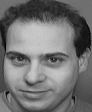

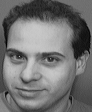

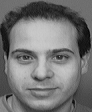

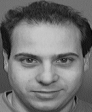

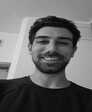

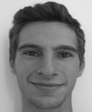

In [ ]:
new_faces_path = "new_faces.zip"
faces_dataset = load_and_display_faces("faces_dataset.zip", new_faces_path,5)

In [ ]:
print(len(faces_dataset))
print(faces_dataset.keys())
print(faces_dataset["new_faces/roy.pgm"].shape)
print(faces_dataset["s9/9.pgm"].shape)

402
dict_keys(['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm', 's1/5.pgm', 's1/6.pgm', 's1/7.pgm', 's1/8.pgm', 's1/9.pgm', 's10/1.pgm', 's10/10.pgm', 's10/2.pgm', 's10/3.pgm', 's10/4.pgm', 's10/5.pgm', 's10/6.pgm', 's10/7.pgm', 's10/8.pgm', 's10/9.pgm', 's11/1.pgm', 's11/10.pgm', 's11/2.pgm', 's11/3.pgm', 's11/4.pgm', 's11/5.pgm', 's11/6.pgm', 's11/7.pgm', 's11/8.pgm', 's11/9.pgm', 's12/1.pgm', 's12/10.pgm', 's12/2.pgm', 's12/3.pgm', 's12/4.pgm', 's12/5.pgm', 's12/6.pgm', 's12/7.pgm', 's12/8.pgm', 's12/9.pgm', 's13/1.pgm', 's13/10.pgm', 's13/2.pgm', 's13/3.pgm', 's13/4.pgm', 's13/5.pgm', 's13/6.pgm', 's13/7.pgm', 's13/8.pgm', 's13/9.pgm', 's14/1.pgm', 's14/10.pgm', 's14/2.pgm', 's14/3.pgm', 's14/4.pgm', 's14/5.pgm', 's14/6.pgm', 's14/7.pgm', 's14/8.pgm', 's14/9.pgm', 's15/1.pgm', 's15/10.pgm', 's15/2.pgm', 's15/3.pgm', 's15/4.pgm', 's15/5.pgm', 's15/6.pgm', 's15/7.pgm', 's15/8.pgm', 's15/9.pgm', 's16/1.pgm', 's16/10.pgm', 's16/2.pgm', 's16/3.pgm', 's16/4.pgm', 's16/5.pgm',

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def calculate_pca_weights(faces_dataset, n_components=400):
    """
    Calculate PCA weights for a dataset of face images.

    Params:
    - faces_dataset: A dictionary containing face images.
    - n_components: The number of principal components to keep.

    Returns:
    - pca: the PCA model.
    - eigenfaces: Principal components of the dataset.
    - weights: PCA weights for the face images.
    """
    # Convert dictionary of face images to a matrix
    # Assuming faces_dataset is your dictionary containing image data
    num_images = len(faces_dataset)
    height, width = list(faces_dataset.values())[0].shape
    face_images = np.zeros((len(faces_dataset), height, width), dtype=np.uint8)  # Initialize array to hold image data

    # Load image data into the array
    for i, image_data in enumerate(faces_dataset.values()):
        face_images[i] = image_data  # Assuming image_data is already in the correct format (e.g., NumPy array)

    # Verify the shape of the array
    flattened_images = face_images.reshape(num_images, -1)
    print(face_images.shape)
    print(flattened_images.shape)

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca.fit(flattened_images)

    # Project original face images onto principal components
    eigenfaces = pca.components_.reshape((n_components, height * width))
    weights = pca.transform(flattened_images)

    return pca, eigenfaces, weights


In [ ]:
pca, eigenfaces, weights = calculate_pca_weights(faces_dataset, 401)
print(pca.components_.shape)
print(eigenfaces.shape)
print(weights.shape)

(402, 112, 92)
(402, 10304)
(401, 10304)
(401, 10304)
(402, 401)


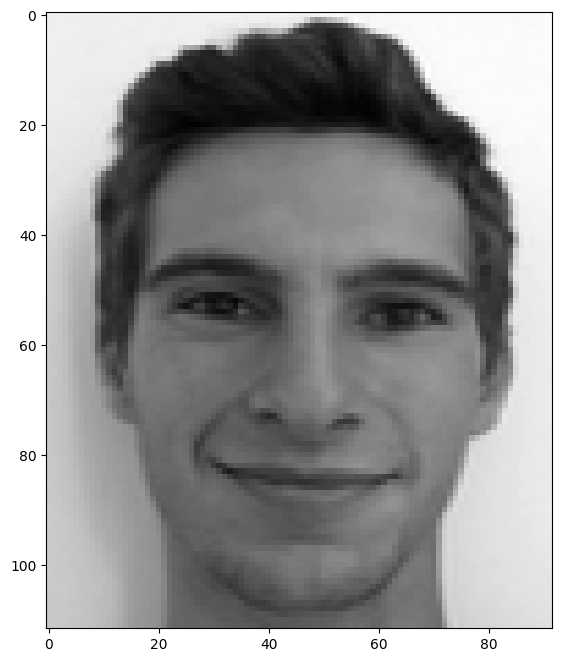

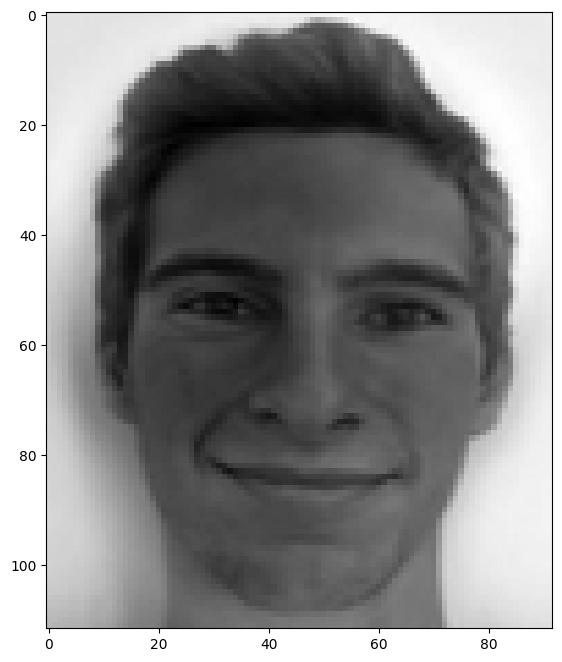

In [ ]:
# sanity check for the pca
# image1 = faces_dataset["s7/1.pgm"].reshape(1, -1)
image1 = faces_dataset["new_faces/roy.pgm"].reshape(1,-1)
weights1 = pca.transform(image1)[0]
reconstructed_image = np.dot(weights1, eigenfaces)
reconstructed_image = reconstructed_image.reshape(112,92)
image1 = image1.reshape(112,92)
plt.imshow(image1, cmap='gray')
plt.show()
plt.imshow(reconstructed_image, cmap='gray')
plt.show()


#### **3.2 Quality vs #PCA elements**

Show improvement in face image quality as a function of the number of PCA decomposition elements used to reconstruct the face image. Plot the Mean Squared Error (MSE) between the source image and the image at different phases of its reconstruction as more eigenfaces are added.

**Plot two graphs:**
1. Generate a linear graph illustrating the error relative to the "zero" round error. This occurs when the initial phase reconstructed image is the average image of all faces. The x-axis represents the number of iterations.

2. Create a logarithmic graph on the y-axis illustrating the same error relative to the "zero" round error. The x-axis corresponds to the number of iterations.

In [ ]:
def calculate_mse_with_visualization(query, eigenfaces, pca, n_components):
    """
    Calculate Mean Squared Error (MSE) between a query image and its PCA reconstruction.
    Additionally, visualize selected iterations with eigenfaces.

    Params:
    - query: The query image.
    - eigenfaces: Principal components of the dataset.
    - pca: PCA model.
    - n_components: The number of principal components to use.

    Returns:
    - mse: Array containing MSE for each iteration.
    """
    # Initialize list to store MSE values
    mse = []

    # Perform reconstruction and visualization for each iteration
    for i in range(1, n_components + 1):
        # Reconstruct the query image using the current number of principal components
        reconstructed_query = np.dot(pca.transform(query.reshape(1, -1))[:, :i], eigenfaces[:i, :])
        reconstructed_query = reconstructed_query + pca.mean_
        reconstructed_query = reconstructed_query.reshape(query.shape)


        # Calculate Mean Squared Error (MSE)
        current_mse = np.mean((query - reconstructed_query) ** 2)
        mse.append(current_mse)

        # Visualize reconstruction at specified iterations
        if i%100 == 0:
            query = query.reshape(112,92)
            reconstructed_query = reconstructed_query.reshape(112,92)
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(query, cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_query, cmap='gray')
            plt.title(f'Reconstructed Image (Iterations: {i})')
            plt.show()

    return mse

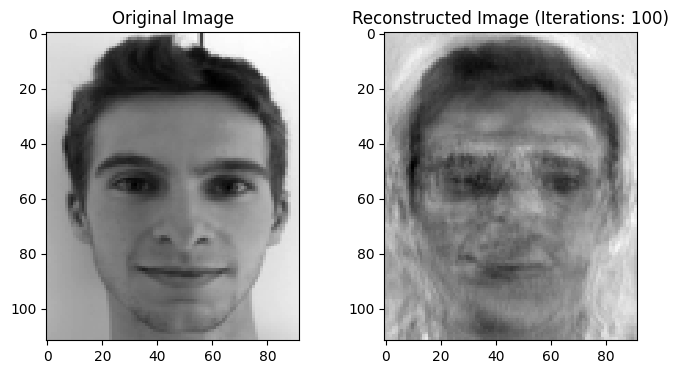

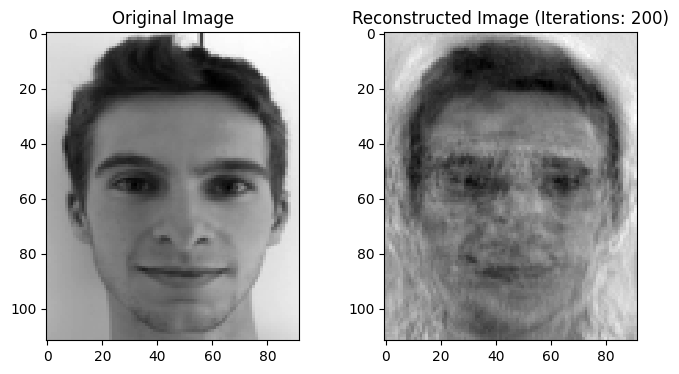

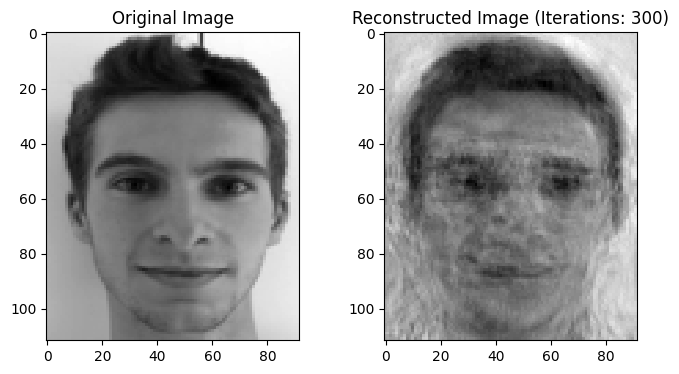

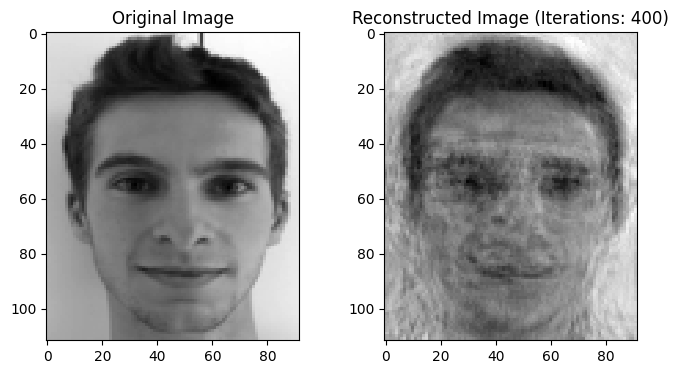

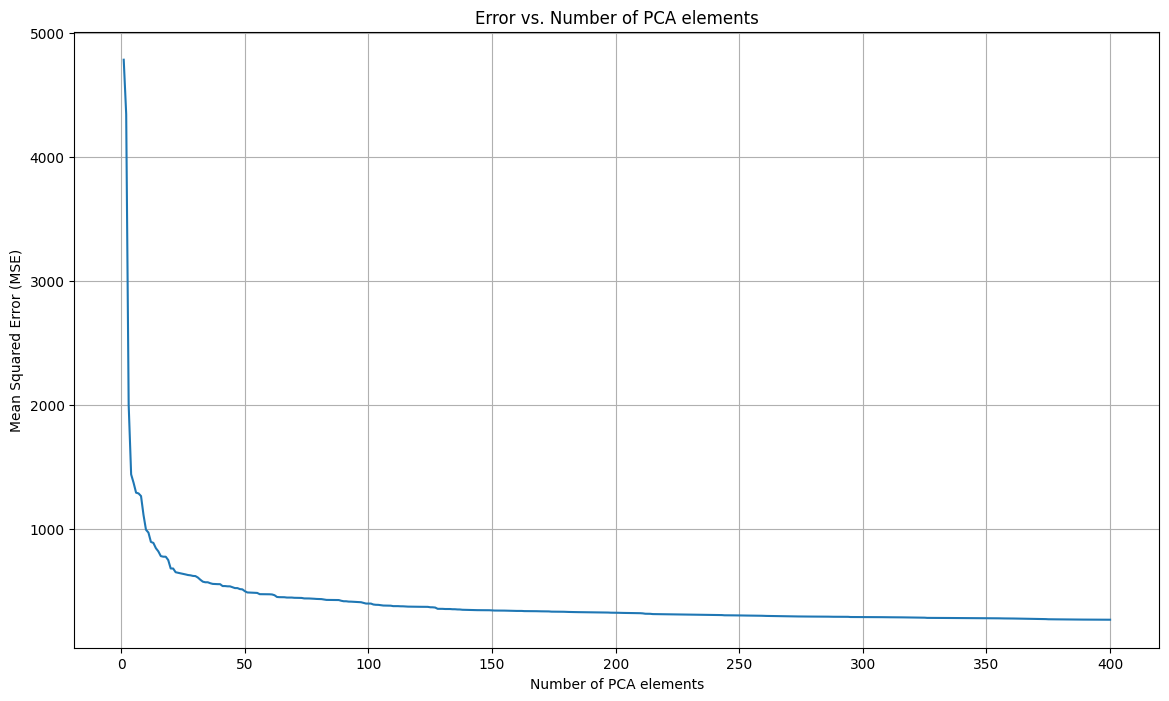

In [ ]:
# Visualize
query_image_path = "roy_query.pgm"
with open(query_image_path, "rb") as image:
    data = np.frombuffer(image.read(), np.uint8)
    query_image = cv2.imdecode(data, cv2.IMREAD_GRAYSCALE)
flattened_query_image = query_image.flatten()

# print(query_image.shape)
# print(flattened_query_image.shape)
n_components = 400
mse_values = calculate_mse_with_visualization(flattened_query_image, eigenfaces, pca, n_components)

# Plot the error as a function of the number of elements in PCA
plt.plot(range(1, n_components + 1), mse_values)
plt.xlabel('Number of PCA elements')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Error vs. Number of PCA elements')
plt.grid(True)
plt.show()


##### **3.3 Morphing**

Write a function that receives two images and displays a morphing process from the first image to the second by gradually changing the PCA weights of the first image to the PCA weights of the second image. Perform the process twice:

1. Morph between face `"s7/1.pgm"` and face `"s7/4.pgm"` in the database.
2. Morph between the two (or three) new face images added earlier.

In [ ]:
def morph(im1, im2, num_iter, eigenfaces, pca):
    """
    Morph between two images gradually changing the PCA weights.

    Params:
    - im1: the source image.
    - im2: the target image.
    - num_iter: the number of phases.
    - faces: Dictionary containing face images.
    - eigenfaces: Principal components of the dataset.
    - pca: PCA model.
    """
    # Compute PCA weights for source and target images
    weights1 = pca.transform(im1)[0]
    weights2 = pca.transform(im2)[0]
    # Initialize morphed images list
    morphed_images = []

    # Interpolate between PCA weights and reconstruct images
    num_iter -= 1
    for i in range(num_iter + 1):
        # Interpolate between PCA weights
        alpha = (num_iter - i)/num_iter
        # print(f"alpha is {alpha}")
        interpolated_weights = alpha * weights1 + (1 - alpha) * weights2

        # Reconstruct the image using interpolated PCA weights
        reconstructed_image = np.dot(interpolated_weights, eigenfaces)

        # Reshape the image to its original shape
        reconstructed_image = reconstructed_image.reshape(112,92)

        # Append the morphed image to the list
        morphed_images.append(reconstructed_image)

    num_iter += 1
    # Display morphed images
    plt.figure(figsize=(12, 6))
    for i, image in enumerate(morphed_images):
        plt.subplot(2, num_iter//2, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Phase {i+1}')
        plt.axis('off')
    plt.show()

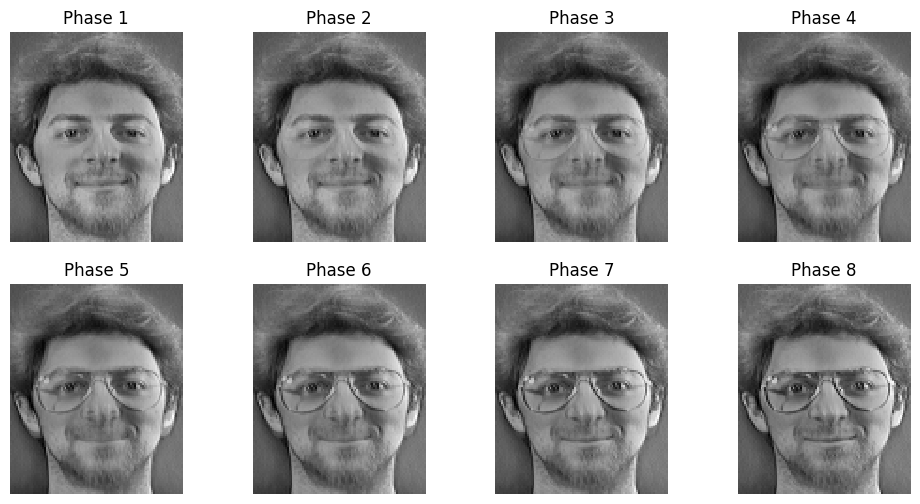

In [ ]:
# Morph between face "s7/1.pgm" and face "s7/4.pgm" in the database
image1 = faces_dataset["s7/1.pgm"].reshape(1, -1)
image2 = faces_dataset["s7/4.pgm"].reshape(1, -1)
morph(image1, image2,8, eigenfaces, pca)

Transitioning from this:


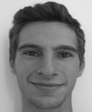

To this:


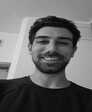

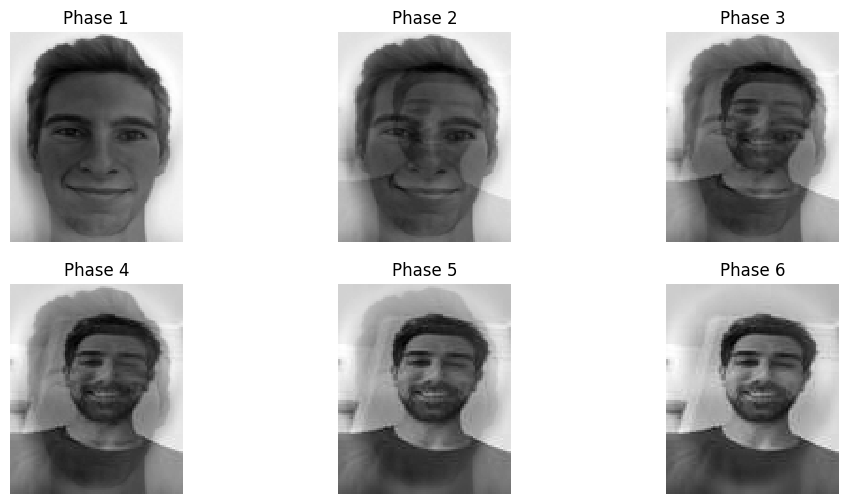

In [ ]:
# Morph between two new face images
student1 = faces_dataset['new_faces/roy.pgm'].reshape(1,-1)
student2 = faces_dataset['new_faces/ofek.pgm'].reshape(1,-1)

print("Transitioning from this:")
cv2_imshow(student1.reshape(112,92))
print("To this:")
cv2_imshow(student2.reshape(112,92))
morph(student1, student2, 6, eigenfaces, pca)